In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import pytz # helps us to localise the timestamps

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

In [ ]:
def wrangle(filename):
  df = pd.read_csv(filename,  index_col="timestamp" )
  df.index = pd.to_datetime(df.index)
  df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

  #creating a mask to remove outliers
  mask_out = df["P2"].between(0,500)
  df = df[mask_out]

  #resampling and imputing missing values using ffil imputing
  df = df["P2"].resample("1h").mean().fillna(method ="ffill").to_frame()

  #creating a Lag feature
  df["P2.L1"] = df["P2"].shift(1)
  df.dropna(inplace = True)

  return df

In [ ]:
df = wrangle("/content/drive/MyDrive/Data for WQU/Project 3/WQU_project3Lesson2.csv")
df.shape

/tmp/ipython-input-1180078975.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df["P2"].resample("1h").mean().fillna(method ="ffill").to_frame()


(2927, 2)

In [ ]:
#first check if the index is of data time format. If it is object the chnage it to datetime by pd.to_datetime() func
#df.index = pd.to_datetime(df.index)
#df.index = pd.to_datetime(df.index)
df.index[:5]

DatetimeIndex(['2018-09-01 04:00:00+03:00', '2018-09-01 05:00:00+03:00',
               '2018-09-01 06:00:00+03:00', '2018-09-01 07:00:00+03:00',
               '2018-09-01 08:00:00+03:00'],
              dtype='datetime64[ns, Africa/Nairobi]', name='timestamp', freq='h')

In [ ]:
#prepare the data
#localizing the timezone to the nairobi timezone
#df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")[:5]

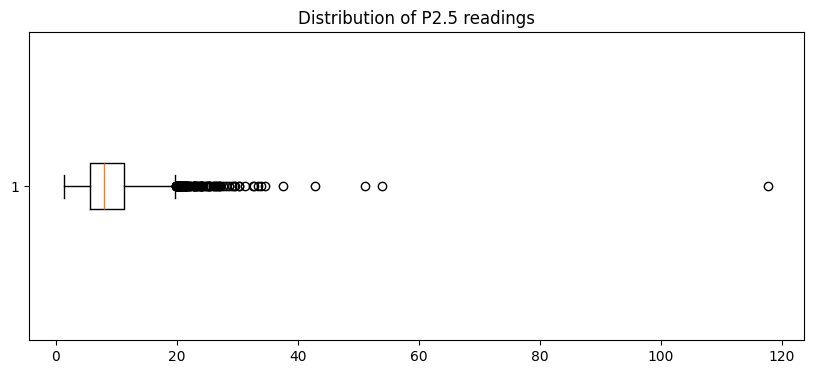

In [ ]:
#Explore the data
#exploring the distribution to identify the outlier
plt.figure(figsize = [10,4])
plt.boxplot(
    df["P2"], vert = False
)
plt.title("Distribution of P2.5 readings");

In [ ]:
#We noted way too much outliers. so we can remove the outliers
#readings over 500 are errors
#df = df[df["P2"].between(0,500)]
#df.head()

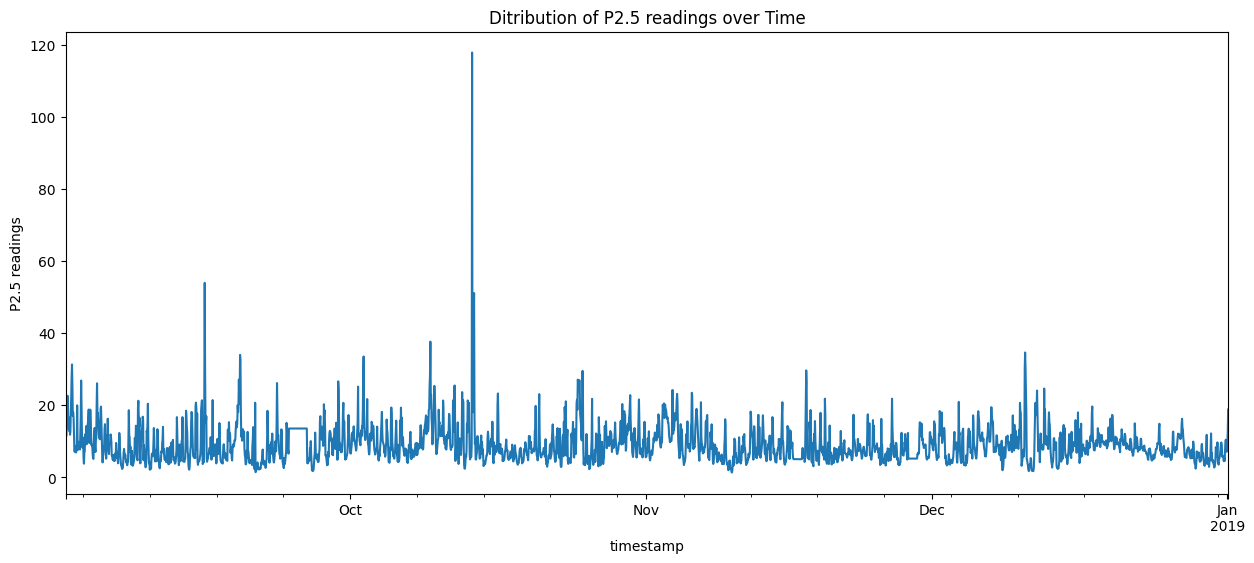

In [ ]:
#creating a timeseries plot
plt.figure(figsize = [15,6])
plt.xlabel("Timestamp")
plt.ylabel("P2.5 readings")
plt.title("Ditribution of P2.5 readings over Time")
df["P2"].plot();

In [ ]:
#we need to adjust the intervals
#and look for missing values
#df["P2"].resample("1h").mean().fillna(method = "ffill").isnull().sum()

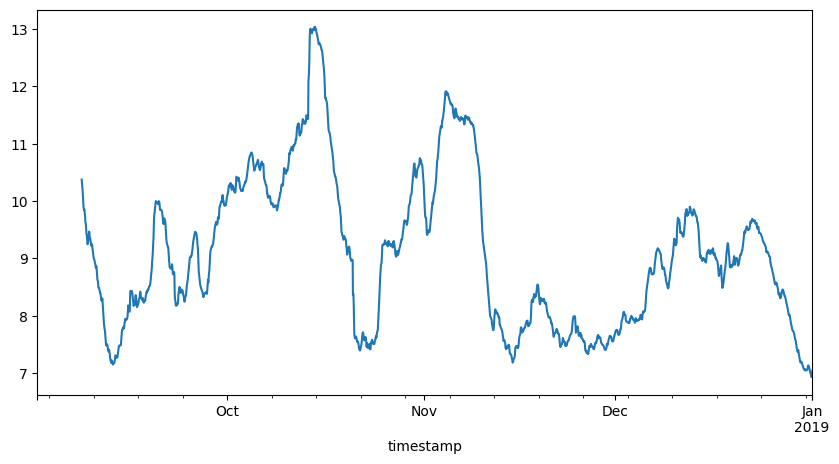

In [ ]:
#Rolling Average or rolling window average
#why do we do rolling window averages?
plt.figure(figsize = [10,5])
df["P2"].rolling(168).mean().plot();


In [ ]:
# we will create a lag since we do not have an X variable to create a function
#df["P2.L1"] = df["P2"].shift(1)
#df.dropna(inplace = True)
#df.head()

<Axes: >

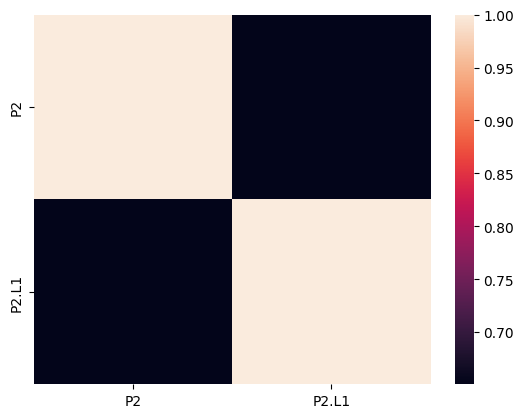

In [ ]:
corr = df.corr()
sns.heatmap(corr)

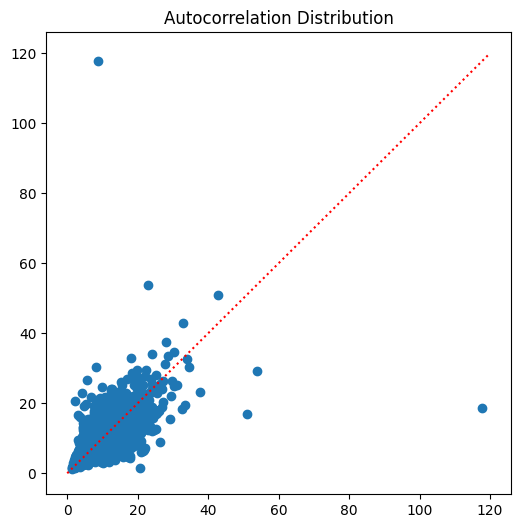

In [ ]:
plt.figure(figsize = [6,6])
plt.scatter(
    x = df["P2.L1"],
    y = df["P2"]
)
plt.plot([0,120],[0,120], color = "red", linestyle = "dotted")
plt.title("Autocorrelation Distribution");

In [ ]:
#doing a vertical split
target = "P2"
y = df[target]
X = df.drop(columns = target)

In [ ]:
X

,P2.L1
timestamp,
2018-09-01 04:00:00+03:00,17.541667
2018-09-01 05:00:00+03:00,15.800000
2018-09-01 06:00:00+03:00,11.420000
2018-09-01 07:00:00+03:00,11.614167
2018-09-01 08:00:00+03:00,17.665000
...,...
2018-12-31 22:00:00+03:00,9.150833
2018-12-31 23:00:00+03:00,7.060833
2019-01-01 00:00:00+03:00,7.854167


In [ ]:
cutoff = int(len(X)*0.8)

#using Iloc to traverse row numbers
#training set
X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]

#testing set
X_test  = X.iloc[cutoff:]
y_test  = y.iloc[cutoff:]

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Baseline mean absolute error:", round(mae_baseline, 2))

Baseline mean absolute error: 3.89


In [ ]:
#creating the model
model = make_pipeline(
    LinearRegression()
)
model.fit(X_train,y_train)

Pipeline(steps=[('linearregression', LinearRegression())])

In [ ]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("The training MAE:", round(mae_training,2))

The training MAE: 2.46


In [ ]:
#lets check it on the testing data
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("The testing MAE:", round(mae_test,2))

The testing MAE: 1.8


In [ ]:
intercept = round(model.named_steps["linearregression"].intercept_,2)
coef = round(model.named_steps["linearregression"].coef_[0],2)

print(f"P2 = {intercept} + ({coef} * P2.L1)")

P2 = 3.36 + (0.64 * P2.L1)


In [ ]:
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred":model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-12-07 17:00:00+03:00,7.070000,8.478927
2018-12-07 18:00:00+03:00,8.968333,7.865485
2018-12-07 19:00:00+03:00,11.630833,9.076421
2018-12-07 20:00:00+03:00,11.525833,10.774814
2018-12-07 21:00:00+03:00,9.533333,10.707836


In [ ]:
fig = px.line(df_pred_test, labels = {"value":"P2"})
fig.show()